# Charlotte Mecklenburg Police Department Citations
### <span style="color:red">(THIS PROJECT IS STILL A WORK IN PROGRESS AND IN DRAFT FORM)</span>

#### The interactive map does not show up in GitHub, so please view the notebook here: [NBVIEWER](https://nbviewer.org/github/hausra5/CMPD-Project/blob/main/CMPD%20Project%20DRAFT.ipynb)

Nobody enjoys getting pulled over by the Police, especially if it results in a citation. The Charlotte Mecklenburg Police Department (CMPD) conducts about 120,000 traffic stops per year. Under North Carolina state law, the CMPD is obligated to collect relevant information on each stop. This information includes demographics on both the driver and officer, the reason for the stop, the result of the stop, when the stop occured, and which division. 

All of this data is provided online through the Charlotte Open Data Portal at https://data.charlottenc.gov/ .  Given all of this information, it will be interesting to visualize reasons and results for getting pulled over. Based on all of the given parameters we can try to see if we can find patterns or potential ways to reduce the likelyhood of being pulled over in the first place.

In this project, we will compare some of the categories and see how they relate to eachother. In doing so, hopefully we can uncover some patterns, that as a driver in Charlotte, we can find ways to avoid the dreaded traffic stop and potential citation that ensues. We will then implement predictive modeling to see if given someone is pulled over, can we correctly predict the result.

To spare you, the reader, all the exploratory visualizations and analysis that I have done, I will focus on showing the relevant outcomes and utilize functions that I have written to cleanly show the results. Below we will import all the necessary libraries and functions to get the project rolling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, roc_curve, auc
from sklearn.naive_bayes import CategoricalNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import geopandas
import geoplot

In [2]:
sns.set_style('darkgrid')
sns.color_palette(palette = 'muted')
plt.rc('axes', titlesize=26)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('font', size=13)

##### Count Plot #####
def count_plot(x,hue,data,axes,hue_order = None, order = None):
    sns.countplot(x=x,hue=hue,data=data,ax=ax[axes], palette = 'muted', hue_order = hue_order, order = order)
    ax[axes].tick_params(axis='x', rotation=45)

##### Stacked Bar #####
def stacked_plot(df,index,columns,axes,order = None):
    #sns.set_theme(style = 'white',palette = 'muted')
    if order:
        df.pivot_table(index = index, columns = columns ,
                        aggfunc='size',fill_value=0, sort = True)[order].plot(kind = 'bar', stacked = True, ax=ax[axes])
    else:
        df.pivot_table(index = index, columns = columns ,
                        aggfunc='size',fill_value=0, sort = True).plot(kind = 'bar', stacked = True, ax=ax[axes])
                                                         
    ax[axes].tick_params(axis='x', rotation=45)

##### Basic Classify #####
def basic_classify(clf, df, features, target, parameters=None, n_jobs=1, n_folds=10, score_func=None):
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.25, random_state = 1)
    if parameters:
        clf = gs_optimize(clf, parameters, X_train, y_train, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_train)
    test_predictions = clf.predict(X_test)
    train_accuracy = accuracy_score(y_train,train_predictions)
    test_accuracy = accuracy_score(y_test,test_predictions)
    cm = confusion_matrix(y_test,test_predictions)
    print("Standard Prediction with 75/25 split - No Cross Validation")
    print('-'*50)
    print("Accuracy on training data: %0.2f" % (train_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(cm)
    print('-'*50)
    print(classification_report(y_test, test_predictions))
    return clf, X_train, y_train, X_test, y_test, test_predictions, cm

##### Grid Search Optimzation #####    
def gs_optimize(clf, parameters, X_train, y_train, n_jobs=1, n_folds=10, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X_train, y_train)
    print('Best Parameters: ', gs.best_params_)
    print('Best Score: ', gs.best_score_)
    best = gs.best_estimator_
    return best

##### Creat Dummies #####
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

####Process Dummies #####
def process_dummies(df,drop_column=None):
    if drop_column:
        columns = df.drop(drop_column,axis=1).columns
    for column in columns:
        df = create_dummies(df,column)
        df.drop(column,axis=1,inplace=True)
    return df

##### Clean Result Multi #####
def clean_result(x):
    if x == 'Verbal Warning' or x == 'No Action Taken':
        return 1
    elif x == 'Citation Issued':
        return 2
    elif x == 'Written Warning':
        return 3
    elif x == 'Arrest':
        return 4
    
##### Clean Result Binary #####
def clean_result_2(x):
    if x == 'Verbal Warning' or x == 'No Action Taken':
        return 0
    else:
        return 1
    
##### Clean DF #####
def clean_df(binned = False, drop_null = False):
    #Read in
    officer = pd.read_csv('officer_traffic_stops.csv')
    
    #Clean Dates
    officer['Month_of_Stop'] = pd.to_datetime(officer['Month_of_Stop'])
    officer['Year'] = officer['Month_of_Stop'].dt.year
    officer['Month_of_Stop'] = officer['Month_of_Stop'].dt.month

    #Drop usesless columns
    officer.drop(['OBJECTID','GlobalID'],axis=1,inplace=True)

    #Combine Hispanic to Driver Race
    officer.loc[officer['Driver_Ethnicity'] == 'Hispanic','Driver_Race'] = 'Hispanic'
    officer.drop('Driver_Ethnicity',axis=1,inplace=True)

    #Clean Officer
    officer['Officer_Race'] = officer['Officer_Race'].str.split(' ').str[0]
    officer['Officer_Race'] = officer['Officer_Race'].str.split('/').str[0]

    def clean_officer(x):
        if x == '2':
            return 'White'
        elif x == 'Not':
            return 'White'
        elif x == 'American':
            return 'Native American'
        else:
            return x

    officer['Officer_Race'] = officer['Officer_Race'].apply(clean_officer)

    #Clean Reason for Stop
    officer['Reason_for_Stop'] = officer['Reason_for_Stop'].str.replace('Vehicle ','')
    officer['Reason_for_Stop'] = officer['Reason_for_Stop'].str.replace('Driving While Impaired   ','DUI')
    officer['Reason_for_Stop'] = officer['Reason_for_Stop'].str.replace('Stop Light/Sign          ','Red Light')
    officer['Reason_for_Stop'] = officer['Reason_for_Stop'].str.replace('Safe Movement            ','Unsafe')
    officer['Reason_for_Stop'] = officer['Reason_for_Stop'].str.split(' ').str[0]
    
    #Clean Driver Race
    officer['Driver_Race'] = officer['Driver_Race'].str.split(' ').str[0]
    officer['Driver_Race'] = officer['Driver_Race'].str.replace('Native','Native American')
    officer['Driver_Race'] = officer['Driver_Race'].str.split('/').str[0]
    
    if binned == True:
        #Driver Age Bins
        cut_points = [-1,19,29,39,49,59,69,100]
        label_names = ['Teenager','20s','30s','40s','50s','60s','Over 60']
        officer['Driver_Age'] = pd.cut(officer['Driver_Age'],cut_points,labels=label_names)

        #Officer Years of Service Bins
        cut_points = [-1,1,5,10,20,30,40]
        label_names = ["First Year","2-5 Years","6-10 Years","11-20 Years","21-30 Years","31-40 Years"]
        officer['Officer_Years_of_Service'] = pd.cut(officer['Officer_Years_of_Service'],cut_points,labels=label_names)
    
    df = officer
    
    if drop_null == True:
        #Drop Null
        df = officer.dropna()    
    return df       

def clean_results(df,clean_function):
    df['Result_of_Stop'] = df['Result_of_Stop'].apply(clean_function)
    features = df.drop('Result_of_Stop',axis=1).columns
    target = 'Result_of_Stop'
    return df,features,target

def k_fold(clf,df,features,target,n_splits = 10):
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 1)
    accuracies = []
    for train_index, test_index, in kf.split(df):
        train = df.iloc[train_index]
        test = df.iloc[test_index]
        clf.fit(train[features],train[target])
        predictions = clf.predict(test[features])
        accuracy = accuracy_score(test[target],predictions)
        accuracies.append(accuracy)
    print(accuracies)
    return accuracies,clf

def create_holdout(df,fraction):
    full_train = df.sample(frac = fraction, random_state = 1)
    holdout = df.loc[~df.index.isin(full_train.index)]
    return full_train,holdout

def display_roc_curve(clf):
    clf_score = clf.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(y_test, clf_score)
    auc_clf = roc_auc_score(y_test, clf_score)

    plt.plot(fpr,tpr,label='AUC:'+str(round(auc_clf,4)))
    plt.title('ROC Curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.rcParams["figure.figsize"] = (5,8)
    plt.show()

def select_features(df,features,target):
    all_X = df[features]
    all_y = df[target]
    
    rf = RandomForestClassifier(random_state = 1)
    selector = RFECV(rf, cv = 10)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print('The Best Columns are: \n','-'*10,best_columns)
    
    return best_columns

def binary_confusion(cm):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    
def create_map():
    df = clean_df(binned=True, drop_null=True)

    cmpd_geo = geopandas.read_file('CMPD_Police_Divisions.geojson')
    cmpd_geo.rename({'DNAME':'CMPD_Division'},axis=1,inplace=True)
    cmpd_geo.drop(['OBJECTID','DIVISION','DIVISION_C'],axis=1,inplace=True)

    pop_geo = geopandas.read_file('Census_Population_Block_Groups.geojson')

    intersect = cmpd_geo.sjoin(pop_geo, how='left')
    intersect.drop(['index_right', 'OBJECTID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10',
           'BLKGRPCE10', 'GEOID10', 'NAMELSAD10', 'geoname','Households', 'Housing_Units', 'Vacancy_Rate', 'Pct_OwnerOccupiedUnits',
                  'OwnerOccupiedUnits', 'GroupQuartersPop', 'Age0_17',
           'Age18_34', 'Age35_64', 'Age65andOver', 'OnePersonHouseholds',
           'TwoPersonHouseholds', 'ThreePersonHouseholds', 'FourPersonHouseholds',
           'FivePersonHouseholds', 'SixPersonHouseholds',
           'SevenOrMorePersonHouseholds', 'SqMi', 'PopSqMi', 'Pop_2010',
           'Pop_Change', 'MedianAge','SHAPESTArea_right','SHAPESTLength_right'],axis=1,inplace=True)

    dissolved = intersect.dissolve('CMPD_Division',aggfunc='sum')
    dissolved['Percent_White'] = round(dissolved['White']/dissolved['Population'],2)
    dissolved['Percent_Black'] = round(dissolved['African_American']/dissolved['Population'],2)
    dissolved['Percent_Hispanic'] = round(dissolved['Hispanic']/dissolved['Population'],2)
    dissolved['Percent_Asian'] = round(dissolved['Asian']/dissolved['Population'],2)

    dummied_new_test = process_dummies(df,'CMPD_Division')

    grouped = dummied_new_test.groupby('CMPD_Division').agg('sum')
    overall_dissolved = pd.merge(left=dissolved, right = grouped, left_index=True, right_index=True)

    full_details_overall_dissolved = overall_dissolved.drop(['Population','White', 'African_American', 'AmerIn_AlaskaNative', 'Asian',
           'NatHawaiian_PacIslander', 'Some_other_race', 'Two_or_more_races',
           'Hispanic','Month_of_Stop_1',
           'Month_of_Stop_2', 'Month_of_Stop_3', 'Month_of_Stop_4',
           'Month_of_Stop_5', 'Month_of_Stop_6', 'Month_of_Stop_7',
           'Month_of_Stop_8', 'Month_of_Stop_9', 'Month_of_Stop_10',
           'Month_of_Stop_11', 'Month_of_Stop_12', 'Officer_Race_Asian', 'Officer_Race_Black',
           'Officer_Race_Hispanic', 'Officer_Race_Native American',
           'Officer_Race_White', 'Officer_Gender_Female', 'Officer_Gender_Male',
           'Officer_Years_of_Service_First Year',
           'Officer_Years_of_Service_2-5 Years',
           'Officer_Years_of_Service_6-10 Years',
           'Officer_Years_of_Service_11-20 Years',
           'Officer_Years_of_Service_21-30 Years',
           'Officer_Years_of_Service_31-40 Years','Driver_Race_Native American', 'Driver_Race_Other', 
                                                            'Driver_Gender_Female', 'Driver_Gender_Male', 'Driver_Age_Teenager',
           'Driver_Age_20s', 'Driver_Age_30s', 'Driver_Age_40s', 'Driver_Age_50s',
           'Driver_Age_60s', 'Driver_Age_Over 60', 'Was_a_Search_Conducted_No',
       'Was_a_Search_Conducted_Yes'],axis=1)

    fdod = full_details_overall_dissolved.copy()

    fdod['Percent_Checkpoint'] = round(fdod['Reason_for_Stop_CheckPoint']/(fdod.iloc[:,7:17].sum(axis=1)),2)
    fdod['Percent_DUI'] = round(fdod['Reason_for_Stop_DUI']/(fdod.iloc[:,7:17].sum(axis=1)),2)
    fdod['Percent_Equipment'] = round(fdod['Reason_for_Stop_Equipment']/(fdod.iloc[:,7:17].sum(axis=1)),2)
    fdod['Percent_Investigation'] = round(fdod['Reason_for_Stop_Investigation']/(fdod.iloc[:,7:17].sum(axis=1)),2)
    fdod['Percent_Other'] = round(fdod['Reason_for_Stop_Other']/(fdod.iloc[:,7:17].sum(axis=1)),2)
    fdod['Percent_Stop_Red'] = round(fdod['Reason_for_Stop_Red']/(fdod.iloc[:,7:17].sum(axis=1)),2)
    fdod['Percent_Regulatory'] = round(fdod['Reason_for_Stop_Regulatory']/(fdod.iloc[:,7:17].sum(axis=1)),2)
    fdod['Percent_Seatbelt'] = round(fdod['Reason_for_Stop_SeatBelt']/(fdod.iloc[:,7:17].sum(axis=1)),2)
    fdod['Percent_Speeding'] = round(fdod['Reason_for_Stop_Speeding']/(fdod.iloc[:,7:17].sum(axis=1)),2)
    fdod['Percent_Unsafe'] = round(fdod['Reason_for_Stop_Unsafe']/(fdod.iloc[:,7:17].sum(axis=1)),2)

    fdod['Percent_Driver_Asian'] = round(fdod['Driver_Race_Asian']/(fdod.iloc[:,17:21].sum(axis=1)),2)
    fdod['Percent_Driver_Black'] = round(fdod['Driver_Race_Black']/(fdod.iloc[:,17:21].sum(axis=1)),2)
    fdod['Percent_Driver_Hispanic'] = round(fdod['Driver_Race_Hispanic']/(fdod.iloc[:,17:21].sum(axis=1)),2)
    fdod['Percent_Driver_White'] = round(fdod['Driver_Race_White']/(fdod.iloc[:,17:21].sum(axis=1)),2)

    fdod['Percent_Arrest'] = round(fdod['Result_of_Stop_Arrest']/(fdod.iloc[:,21:26].sum(axis=1)),2)
    fdod['Percent_Citation'] = round(fdod['Result_of_Stop_Citation Issued']/(fdod.iloc[:,21:26].sum(axis=1)),2)
    fdod['Percent_None'] = round(fdod['Result_of_Stop_No Action Taken']/(fdod.iloc[:,21:26].sum(axis=1)),2)
    fdod['Percent_Verbal_Warning'] = round(fdod['Result_of_Stop_Verbal Warning']/(fdod.iloc[:,21:26].sum(axis=1)),2)
    fdod['Percent_Written_Warning'] = round(fdod['Result_of_Stop_Written Warning']/(fdod.iloc[:,21:26].sum(axis=1)),2)

    fdod['Percent_Warning'] = round(fdod['Percent_None'] + fdod['Percent_Verbal_Warning'] +
                                    fdod['Percent_Written_Warning'],2)

    df = fdod[['geometry', 'SHAPESTArea_left', 'SHAPESTLength_left',
              'Percent_White','Percent_Driver_White',
              'Percent_Black','Percent_Driver_Black',
              'Percent_Hispanic','Percent_Driver_Hispanic',
               'Percent_Regulatory', 'Percent_Speeding','Percent_Equipment',
               'Percent_Stop_Red','Percent_Unsafe',
              'Percent_Citation','Percent_Warning',]].reset_index()
    return df

### Cleaning the Data
When using datasets that are created by someone else, there is a very good chance some cleaning will be required. This dataset was no different. Most of the columns contained a large amount of empty spaces after the data. For example, <code>'Safe Movement        '</code> was one of the inputed text. Fixing all of these inconsitencies and choosing simpler words helped when trying to quickly select and visualize categories. 

Other items that I decide to clean was separating months from years to see if specific Months offered any interesting insight. I also had to clean out the Race categories to help group those better to help see patterns. 

Furthermore, I decided to bin the driver age and the officers years of service. This way we could condense down the value counts for each of these categories to help with visualizations and when running our Machine Learning algorithms. The bins were chosen based on the distribution and standard deviation of the data.

Lastly, about two percent of the data had null values for the CMPD Division. When looking at the distributions of counts on each parameter for the null CMPD Division, the distributions were very similar to the rest of the Divisions with no striking differences. The only major difference for these null CMPD Divions was the result of the stop was for an <code>'Other'</code> reason. For our final visualizations and predictive modeling, we dropped these rows to keep everything cleaner.

### Visualizing for Patterns
Now we can run one of our functions to load in the cleaned dataset and begin our journey to never getting a ticket again!

Let's get acquainted with our data and then take a look at two very important columns, the reasons and results of a traffic stop.

In [3]:
CMPD = clean_df(binned=True, drop_null=True)

In [4]:
CMPD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132238 entries, 0 to 135993
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   Month_of_Stop             132238 non-null  int64   
 1   Reason_for_Stop           132238 non-null  object  
 2   Officer_Race              132238 non-null  object  
 3   Officer_Gender            132238 non-null  object  
 4   Officer_Years_of_Service  132238 non-null  category
 5   Driver_Race               132238 non-null  object  
 6   Driver_Gender             132238 non-null  object  
 7   Driver_Age                132238 non-null  category
 8   Was_a_Search_Conducted    132238 non-null  object  
 9   Result_of_Stop            132238 non-null  object  
 10  CMPD_Division             132238 non-null  object  
 11  Year                      132238 non-null  int64   
dtypes: category(2), int64(2), object(8)
memory usage: 11.4+ MB


We can see that our dataset contains 132,238 traffic stops with no null values. Let's explore further.

In [5]:
CMPD.head()

,Month_of_Stop,Reason_for_Stop,Officer_Race,Officer_Gender,Officer_Years_of_Service,Driver_Race,Driver_Gender,Driver_Age,Was_a_Search_Conducted,Result_of_Stop,CMPD_Division,Year
0,1,Speeding,White,Male,21-30 Years,White,Female,30s,No,Verbal Warning,University City Division,2020
1,5,Equipment,Hispanic,Female,2-5 Years,Black,Male,30s,No,Verbal Warning,Providence Division,2021
2,1,Equipment,White,Female,2-5 Years,Black,Male,30s,No,Verbal Warning,University City Division,2020
3,1,Speeding,White,Male,21-30 Years,Black,Male,30s,No,Citation Issued,Steele Creek Division,2020
4,1,Regulatory,Hispanic,Male,2-5 Years,Hispanic,Male,30s,No,Verbal Warning,Eastway Division,2020


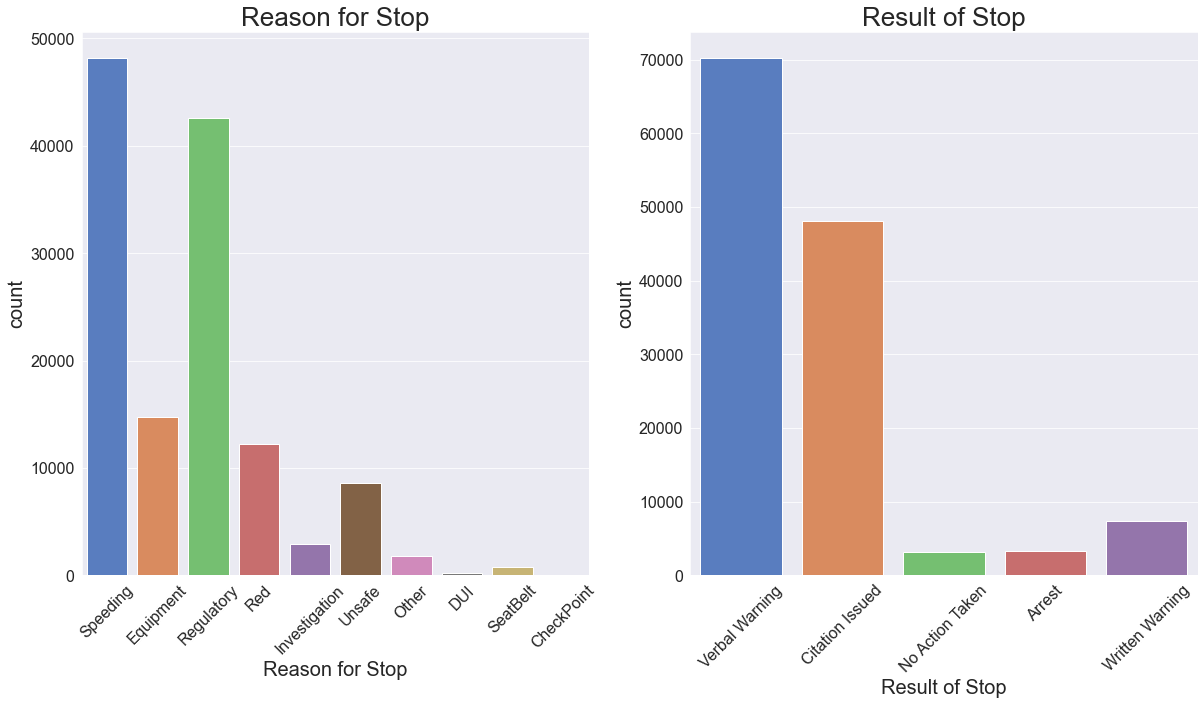

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
count_plot('Reason_for_Stop',None,CMPD,0)
count_plot('Result_of_Stop',None,CMPD,1) 

ax[0].set(title='Reason for Stop',xlabel='Reason for Stop',ylabel='count')

ax[1].set(title='Result of Stop',xlabel='Result of Stop',ylabel='count')

plt.show()

Looking at the Reasons, we can see that Speeding and Regulatory (ie. expired registrations, no tags, etc.) account for the majority of reasons for stops. Also, the majority of the time, the driver is being let go with just a verbal warning.

In [7]:
CMPD['Reason_for_Stop'].value_counts(normalize=True)

Speeding         0.364547
Regulatory       0.322267
Equipment        0.111435
Red              0.092644
Unsafe           0.065420
Investigation    0.022104
Other            0.013521
SeatBelt         0.006050
DUI              0.001459
CheckPoint       0.000552
Name: Reason_for_Stop, dtype: float64

In [8]:
CMPD['Result_of_Stop'].value_counts(normalize=True)

Verbal Warning     0.531466
Citation Issued    0.363526
Written Warning    0.055808
Arrest             0.025023
No Action Taken    0.024176
Name: Result_of_Stop, dtype: float64

Given that Speeding is about 36% of all traffic stops and the Regulatory is 32%, it will be interesting to see how this compares to the overall result, given 53% of the time, the driver is let off with a verbal warning.

Let's visualize this further by the exploring the results in a couple different ways. First we can see the overall count given the data skews heavily towards Speeding and Regulation reasons. However, there are bunch of other potential reasons to be pulled over, just significantly less likely. It will be interesting to see how the results are different for these more rare occurances.

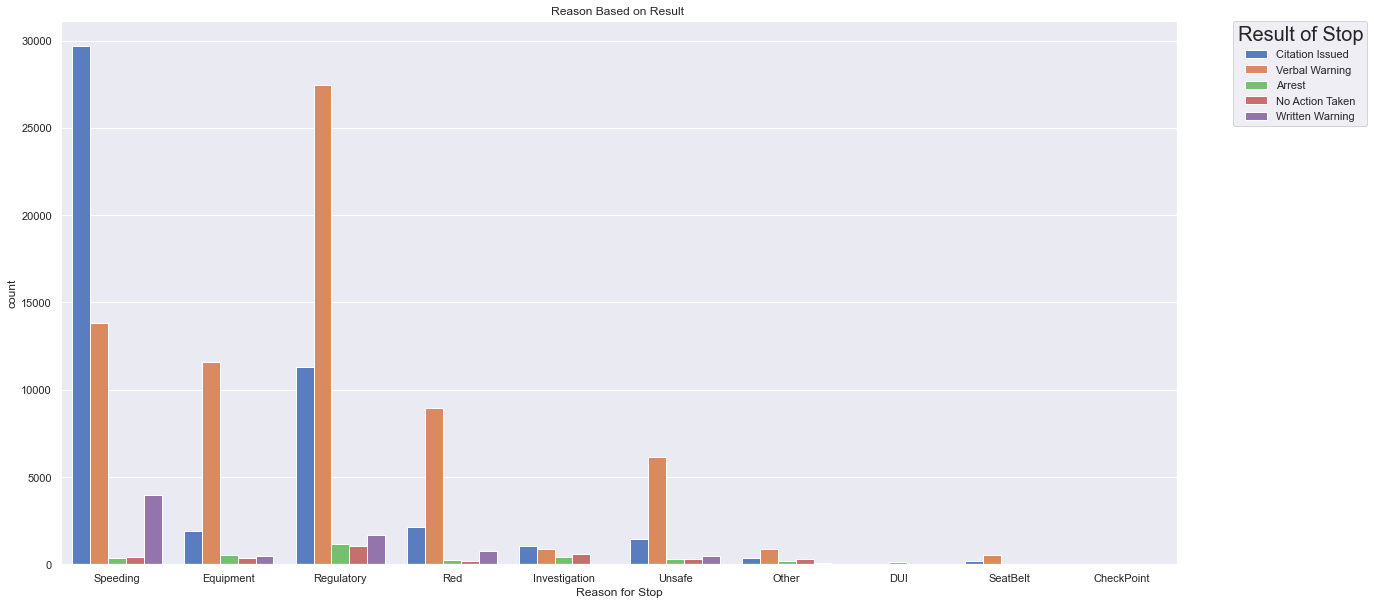

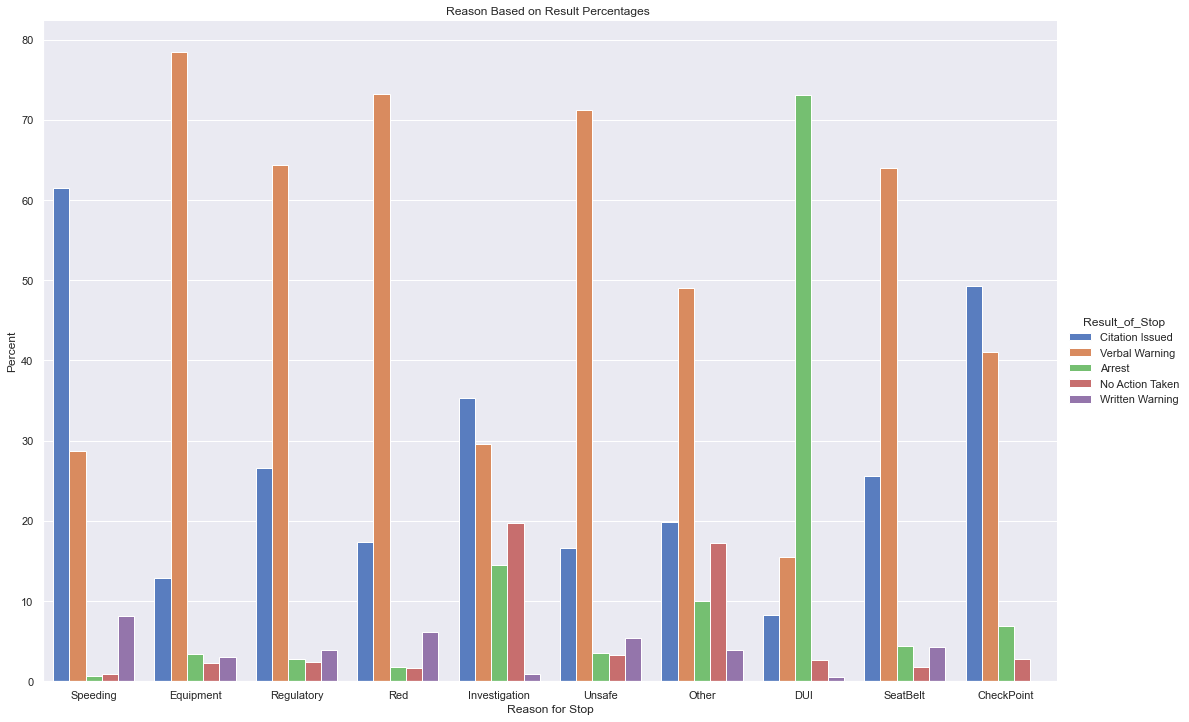

In [9]:
sns.set_theme(palette = 'muted')
plt.figure(figsize=(20,10))
ax1 = sns.countplot(x='Reason_for_Stop',hue='Result_of_Stop',data=CMPD,
                    hue_order = ['Citation Issued','Verbal Warning','Arrest','No Action Taken','Written Warning']
                    )
ax1.set(title='Reason Based on Result ',xlabel='Reason for Stop',ylabel='count')
ax1.legend(title='Result of Stop',title_fontsize='20',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax2 = (CMPD.groupby('Reason_for_Stop')['Result_of_Stop'].value_counts(normalize=True).mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x='Reason_for_Stop',y='percent',hue='Result_of_Stop',kind='bar',height=10, 
      aspect=1.5,legend=True,legend_out=True, 
     order = ['Speeding','Equipment','Regulatory','Red','Investigation','Unsafe','Other','DUI','SeatBelt','CheckPoint'])
      ).set(title='Reason Based on Result Percentages ',xlabel='Reason for Stop',ylabel='Percent')
plt.show()

For the top two reasons of being pulled over, if it's for speeding, you're about twice as likely to get a ticket over a verbal warning. However, if it's for regulatory reasons, the opposite is true.

Looking at the percentages for each reason, not surprisingly, a DUI typically results in an arrest. The only other two catgories besides Speeding with a higher percentage of citations over verbal warning are Checkpoints and Investigations.

### Exploring Categorical Relationships
Now that we have a better feel for the reasons and results of the traffic stops. Let's start exploring how different features potentially affect both the reason and results.

Here we will focus on a few categories that offered meaningful relationships. These consist of the Month of the incident, the Officers experience level, Driver age, Driver Race, and finally we will then explore the different Divisions and how geographically in Charlotte the reasons and results change based on zip code.

### Month of Traffic Stop
As a driver, we may suspect that certain times of the year may have higher police activity. We can visualize the Reasons for stops based on Month to get an idea if any patterns may emerge.

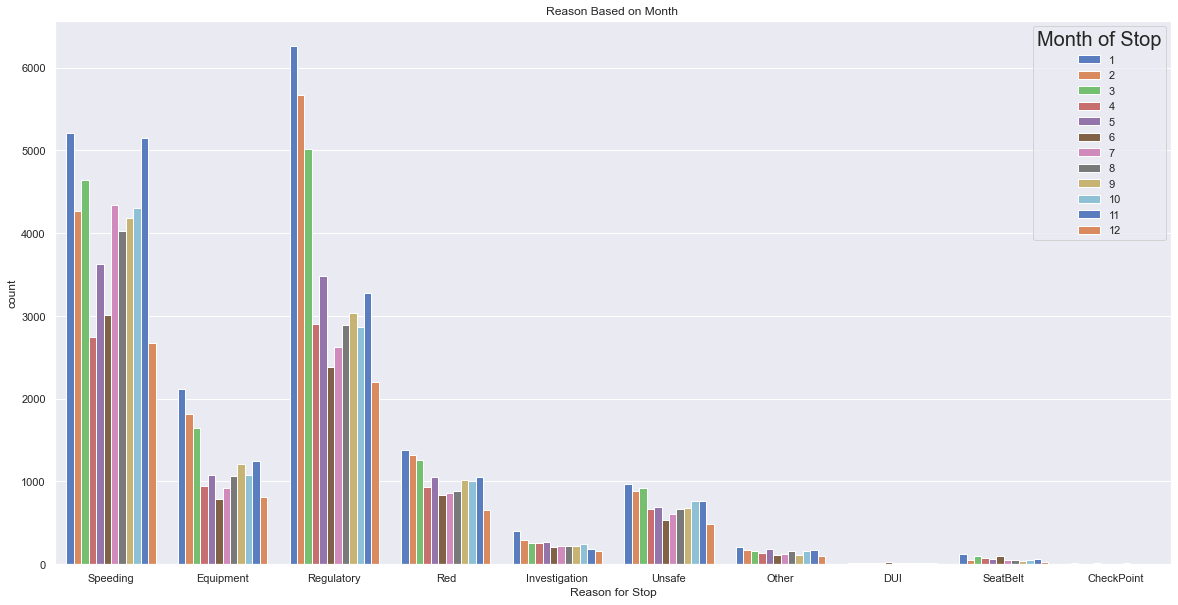

In [10]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='Reason_for_Stop',hue='Month_of_Stop',data=CMPD,palette='muted')
ax.set(title='Reason Based on Month ',xlabel='Reason for Stop',ylabel='count')
ax.legend(title='Month of Stop',title_fontsize='20',loc='upper right')
plt.show()

Interestingly, the majority of regulatory and equipment related stops are in January, February, and March. Either a lot of people are delaying getting their car inspected in the beginning of the year, or the Police may be out looking for this to hit yearly quotas early on. Similarily, speeding is most prevalent in the beginning of the year, however Novbember seems to be a hot month to receive a speeding ticket. Again, this could be year end quotas, with December being lower potentially due to end of year vacations.

### Officer Tenure
Next up, we'd imagine that the seniority of the officer may result in them being stationed in different areas, or put on different duties. New officers may need to prove themselves and are put to work in more difficult areas.

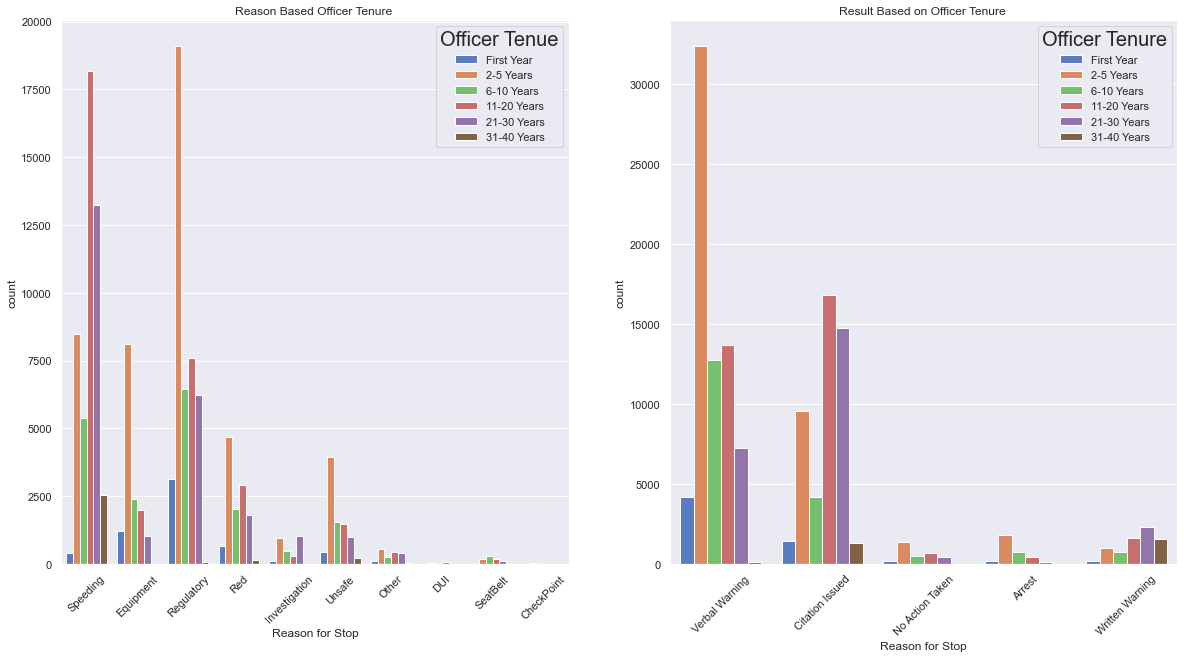

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax1 = count_plot('Reason_for_Stop','Officer_Years_of_Service',CMPD,0)
ax2 = count_plot('Result_of_Stop','Officer_Years_of_Service',CMPD,1)

ax[0].set(title='Reason Based Officer Tenure ',xlabel='Reason for Stop',ylabel='count')
ax[0].legend(title='Officer Tenue',title_fontsize='20',loc='upper right')

ax[1].set(title='Result Based on Officer Tenure ',xlabel='Reason for Stop',ylabel='count')
ax[1].legend(title='Officer Tenure',title_fontsize='20',loc='upper right')

plt.show()

It seems that the younger officers are pulling over drivers for mostly Regulatory and Equipment related reasons. The more senior officers predominatley pull over drivers for speeding. The Results paint the same picture, with the younger officers giving out more verbal warnings probably due to Regulatory reasons, where as the older officers are giving out the citations, likley for speeding.

A potential explanation for the age descrepency is the more senior the officer, they might be stationed in a different area, as well as, rather than patroling around, they may spend most of the time looking for speeders on the highways.

We can inspect this further by grouping the data based on officer tenure and visualizing the Reason vs Results again.

In [12]:
young = CMPD[((CMPD['Officer_Years_of_Service'] == 'First Year') | (CMPD['Officer_Years_of_Service'] == '2-5 Years') | (CMPD['Officer_Years_of_Service'] == '6-10 Years'))
              & ((CMPD['Reason_for_Stop'] == 'Speeding') | (CMPD['Reason_for_Stop'] == 'Regulatory'))]
old = CMPD[((CMPD['Officer_Years_of_Service'] == '11-20 Years') | (CMPD['Officer_Years_of_Service'] == '21-30 Years') | (CMPD['Officer_Years_of_Service'] == '31-40 Years'))
          & ((CMPD['Reason_for_Stop'] == 'Speeding') | (CMPD['Reason_for_Stop'] == 'Regulatory'))]

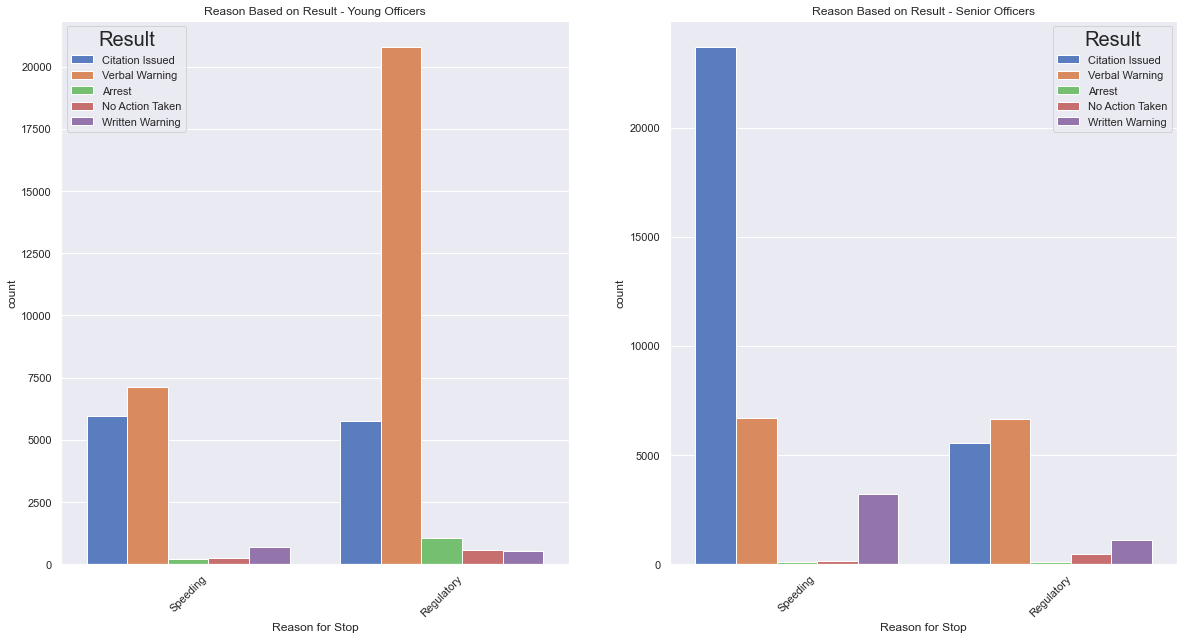

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax1 = count_plot('Reason_for_Stop','Result_of_Stop',young,0, hue_order = ['Citation Issued','Verbal Warning',
                                                                         'Arrest','No Action Taken','Written Warning'],
                order = ['Speeding','Regulatory'])
ax2 = count_plot('Reason_for_Stop','Result_of_Stop',old,1,hue_order = ['Citation Issued','Verbal Warning',
                                                                         'Arrest','No Action Taken','Written Warning'])

ax[0].set(title='Reason Based on Result - Young Officers',xlabel='Reason for Stop',ylabel='count')
ax[0].legend(title='Result',title_fontsize='20',loc='upper left')

ax[1].set(title='Reason Based on Result - Senior Officers',xlabel='Reason for Stop',ylabel='count')
ax[1].legend(title='Result',title_fontsize='20',loc='upper right')

plt.show()

Surprisngly, Younger officers seem to give out more verbal warning in general, even when speeding is the reason for the traffic stop. Older officers give dramatically more citations compared to verbal warnings when it comes to speeding. Although, as a whole, senior officers pull over significantly more people for speeding, so it could be that more senior officers tend to pull over drivers that are egregiously speeding based on the area compared to younger officers.

### Driver Age
Thinking back to when I was younger, my driving habits have changed pretty dramatically. I'd imagine the same holds true for most drivers out there. We can explore this by visualizing the reasons a driver might be pulled over based on their age.

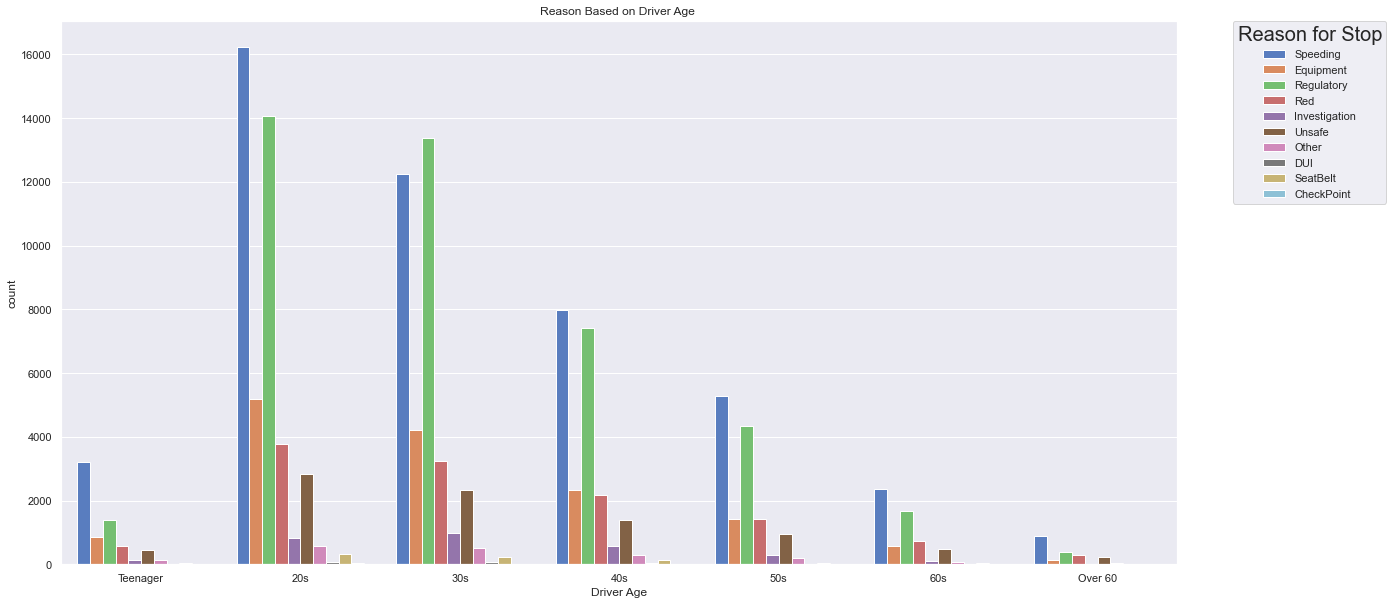

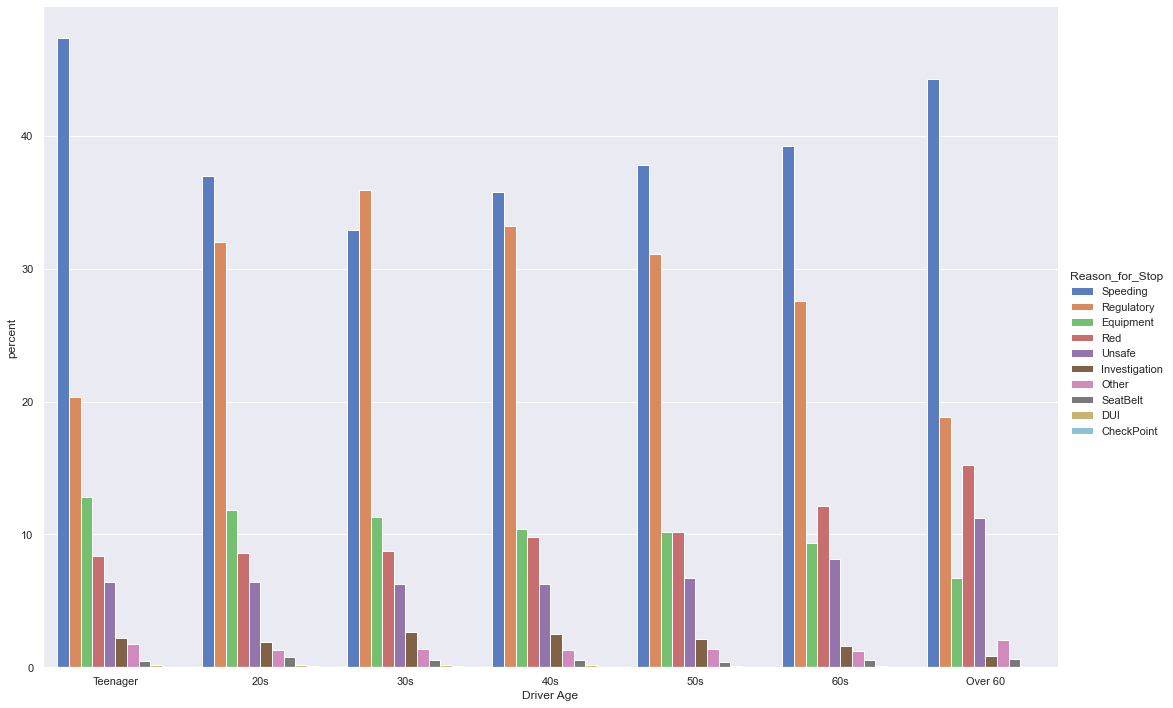

In [14]:
plt.figure(figsize=(20,10))

ax1 = sns.countplot(x='Driver_Age',hue='Reason_for_Stop',data=CMPD,palette ='muted')
ax1.set(title='Reason Based on Driver Age ',xlabel='Driver Age',ylabel='count')
ax1.legend(title='Reason for Stop',title_fontsize='20',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax2 = (CMPD.groupby('Driver_Age')['Reason_for_Stop'].value_counts(normalize=True).mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x='Driver_Age',y='percent',hue='Reason_for_Stop',kind='bar',height=10, aspect=1.5,palette = 'muted'))
plt.xlabel('Driver Age')
plt.show()

Looking at the visualizations, the majority of traffic stops are from those in their 20's and 30's and it's typically for speeding or regulatory reasons.

Interestingly enough, although the amount of traffic stops for Teenagers and those over 60 is low, it's predominately for speeding.

### Driver Race
There has been a lot of publicity about racial injustices within Police Departments. It would only make sense to explore this category further as it's a very important topic in todays culture.

In [15]:
CMPD['Driver_Race'].value_counts(normalize=True)

Black              0.562312
White              0.265552
Hispanic           0.131611
Other              0.022732
Asian              0.017189
Native American    0.000605
Name: Driver_Race, dtype: float64

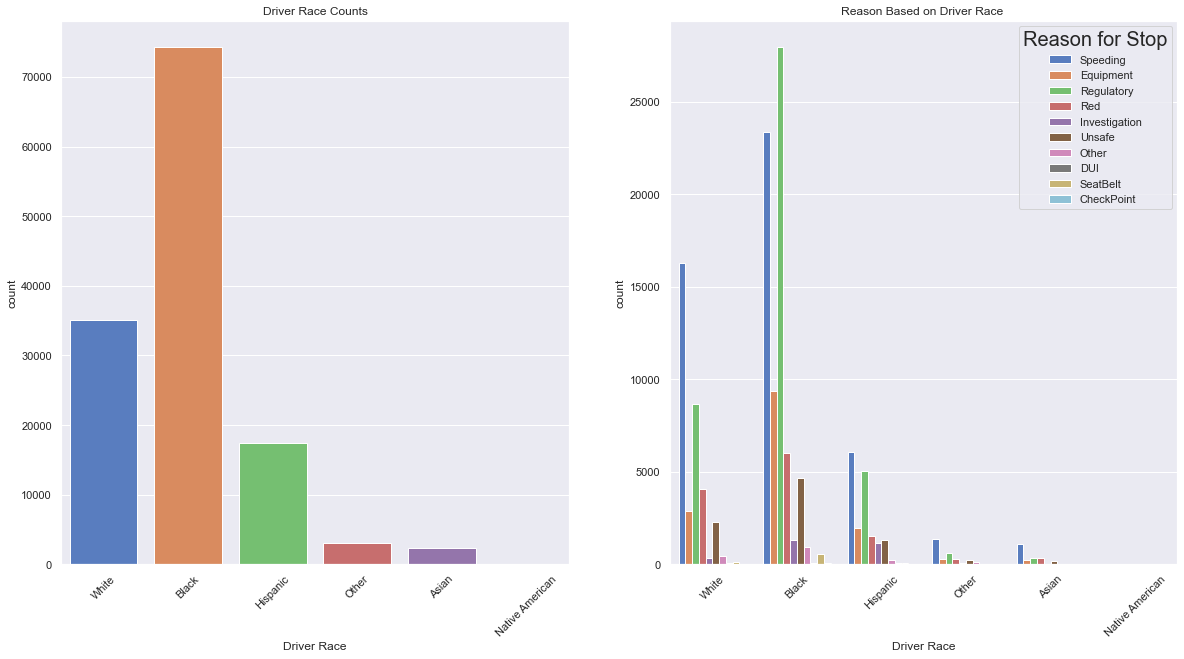

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
count_plot('Driver_Race',None,CMPD,0)
count_plot('Driver_Race','Reason_for_Stop',CMPD,1)

ax[0].set(title='Driver Race Counts',xlabel='Driver Race',ylabel='count')

ax[1].set(title='Reason Based on Driver Race ',xlabel='Driver Race',ylabel='count')
ax[1].legend(title='Reason for Stop',title_fontsize='20',loc='upper right')

plt.show()

We can see that 56% of all traffic stops involve an African American, where as, only 26% of all traffic stops involve a white person. This seems pretty disproportionate given that Charlotte's total population is about 32% African American and 54% White. Hispanics account for about 13% of the total population, so those traffic stops don't seem to be disproporitionate.

Looking at the reasons for the traffic stops, it seems that the majority of stops involving African Americans are for Regulatory, Speeding, and Equipment in that order. Where as for White people, it's predominately for Speeding with Regulatory being almost 50% less.

Let's see if we can investigate this further to see if we can uncover any major reasons for the differences amongst races.

First, we should make sure, given the reason, race doesn't result in a higher citation risk.

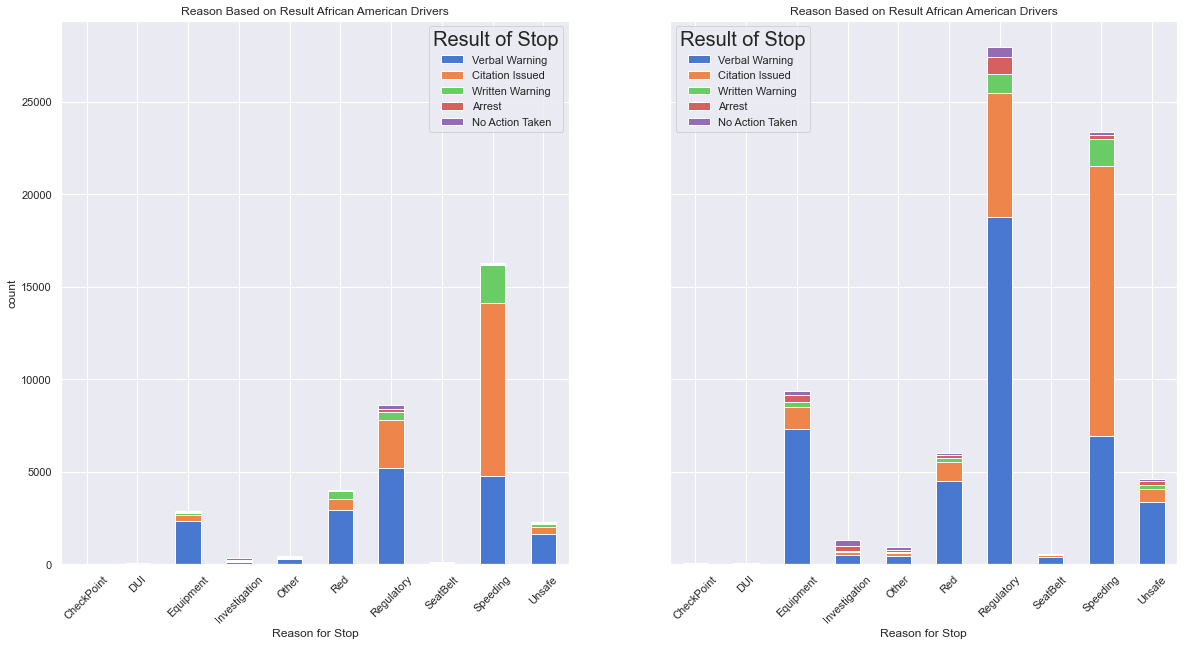

White Results: 
--------------------------------------------------
Verbal Warning     0.498548
Citation Issued    0.379030
Written Warning    0.093689
No Action Taken    0.016517
Arrest             0.012217
Name: Result_of_Stop, dtype: float64
--------------------------------------------------
African American Results: 
--------------------------------------------------
Verbal Warning     0.568700
Citation Issued    0.333625
Written Warning    0.042187
Arrest             0.033822
No Action Taken    0.021665
Name: Result_of_Stop, dtype: float64


In [17]:
white = CMPD[CMPD['Driver_Race'] == 'White']
african_american = CMPD[CMPD['Driver_Race'] == 'Black']

sns.set_theme(palette = 'muted')
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey = 'all')

white.pivot_table(index = 'Reason_for_Stop', columns = 'Result_of_Stop' ,
                        aggfunc='size',fill_value=0, sort = True)[['Verbal Warning','Citation Issued','Written Warning','Arrest', 'No Action Taken']].plot(kind = 'bar', stacked = True, ax=ax[0],
                        title='Reason Based on Result African American Drivers',xlabel='Reason for Stop',ylabel='count')
african_american.pivot_table(index = 'Reason_for_Stop', columns = 'Result_of_Stop' ,
                        aggfunc='size',fill_value=0, sort = True)[['Verbal Warning','Citation Issued','Written Warning','Arrest', 'No Action Taken']].plot(kind = 'bar', stacked = True, ax=ax[1],
                        title='Reason Based on Result African American Drivers',xlabel='Reason for Stop',ylabel='count')

ax[0].legend(title='Result of Stop',title_fontsize='20',loc='upper right')
ax[0].tick_params(axis='x', rotation=45)

ax[1].legend(title='Result of Stop',title_fontsize='20',loc='upper left')
ax[1].tick_params(axis='x', rotation=45)
plt.show()

print('White Results: ')
print('-'*50)
print(white['Result_of_Stop'].value_counts(normalize=True))
print('-'*50)
print('African American Results: ')
print('-'*50)
print(african_american['Result_of_Stop'].value_counts(normalize=True))

Proportionately, the distribution is similar. Roughly 50% of the results are verbal warnings for White and 56% for African Americans. 37% citations for White and 33% for African Americans. Nothing too glaring here.

Ultimately, we have to try to investigate further as to why African Americans are being pulled over at a significantly higher rate.

Looking back at our previous visualizations, we saw that the younger the officer is, the more likely he is to pull over someone for Regulatory reasons. We assumed this could be based geographically or where they are stationed. They could also just be patrolling more looking for reasons to pull over somone. Given that we just saw that African Americans seem to be pulled over quite frequently for Regulatory reasons, we should begin taking a look at the individual Divisions and how it relates geographically to Charlotte's Demographics. This could help explain the reasoning for traffic stops clearer.

### CMPD Division and Charlotte Demographics
We'd like to hope that underlying racism is not the reason for the increased traffic stops based on race. In our dataset, the CMPD Division is given. Each CMPD division accounts for certain areas in Charlotte. Using this information, I was able to combine three different datasets to help visualize Charlotte's geography and how the Traffic Stops within each Division relates to Charlotte's overall demographics.

I created a function that maps this out for us to see. On the map, we can see each Division and the area they control. As you hover over the map, you can see the percentages of Charlotte's Demographics for area, the traffic stop driver demographics, reasons for the stop, and the results of the stops. As you hover over the areas, we can see some major population vs traffic stop discrepancies. For example, in University City, African Americans only account for 47% of the population, but 70% of the traffic stops.

In [18]:
charlotte = create_map()
charlotte.explore('CMPD_Division',style_kwds={'fillOpacity' : .65})

As the reader, please feel free to explore the map further, but I will continue to show some Divisional graphs to help understand the Divionsal differences.

In [19]:
CMPD['CMPD_Division'].value_counts(normalize=True)

South Division              0.113606
North Division              0.097778
Providence Division         0.097272
University City Division    0.087184
Metro Division              0.082178
Independence Division       0.080884
Eastway Division            0.077429
Freedom Division            0.074162
Hickory Grove Division      0.072347
North Tryon Division        0.069261
Central Division            0.061041
Westover Division           0.050961
Steele Creek Division       0.035897
Name: CMPD_Division, dtype: float64

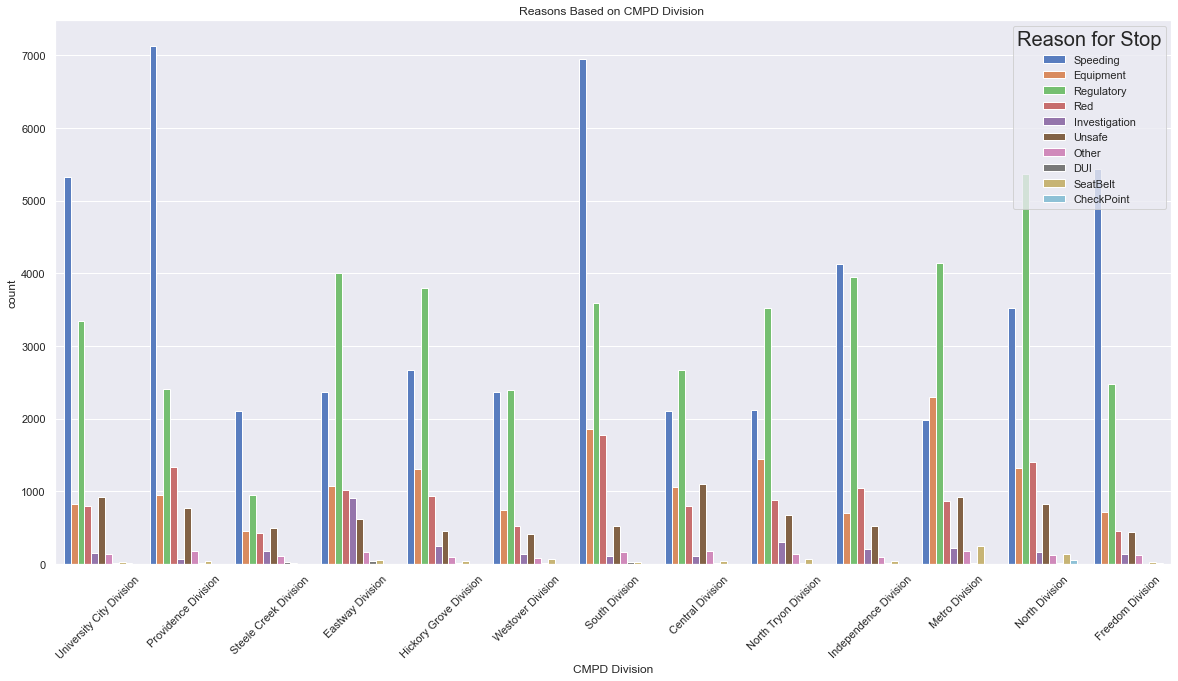

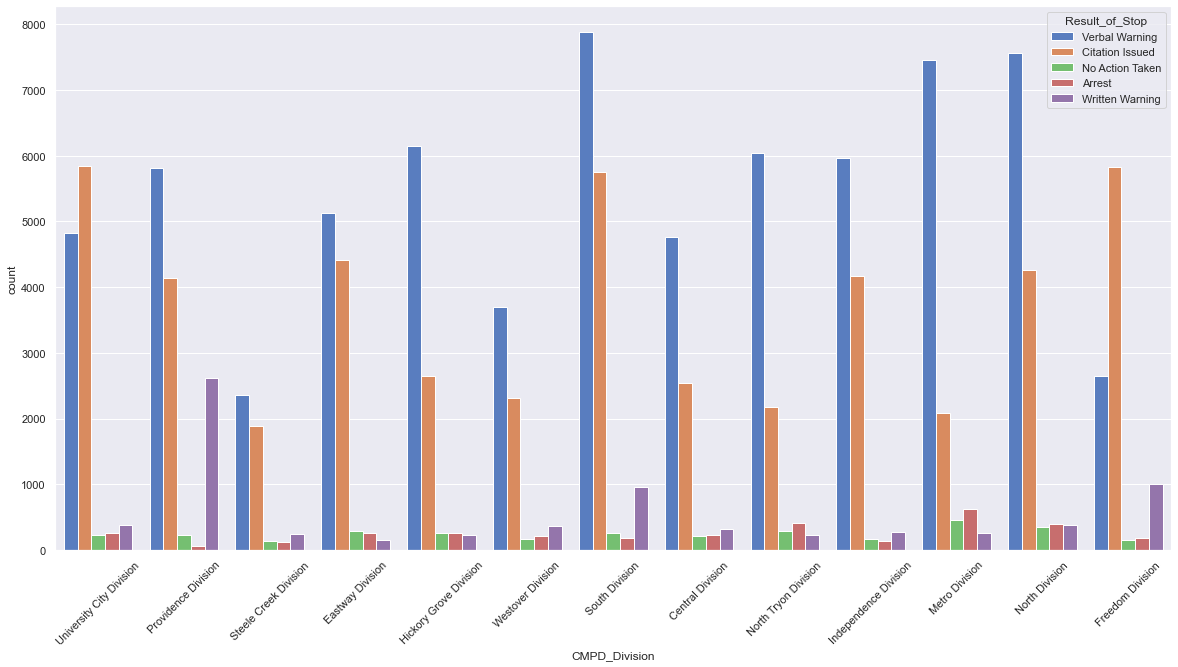

In [20]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='CMPD_Division',hue='Reason_for_Stop',data=CMPD,palette ='muted')
ax.set(title='Reasons Based on CMPD Division ',xlabel='CMPD Division',ylabel='count')
ax.legend(title='Reason for Stop',title_fontsize='20',loc='best')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(20,10))
sns.countplot(x='CMPD_Division',hue='Result_of_Stop',data=CMPD,palette ='muted')
ax.set(title='Result Based on CMPD Division ',xlabel='CMPD Division',ylabel='count')
ax.legend(title='Result of Stop',title_fontsize='20',loc='upper left')
plt.xticks(rotation=45)
plt.show()

Looking at these graphs, we can see that University, Providence, Freedom and South all have very high speeding related traffic stops. We can see that North, Metro, Eastway, and Hickory Grove have higher amounts of Regulatory traffic stops. Independence has both high Regulatory and Speeding stops.

As we look at the results of these stops, we can see a few relatively surprisngly observations. The North and Metro have similar Verbal Warning outcomes, however, the North had a fair amount more Regulatory stops in comparison. More interestingly, both Freedom and University had higher citations when compared to the South and Providence Division, despite the majority of stops were for speeding. Exploring these 6 divisions a bit further might offer some insight.

First, let's take a look at how Driver Race is distrubted amongst the Divisions.

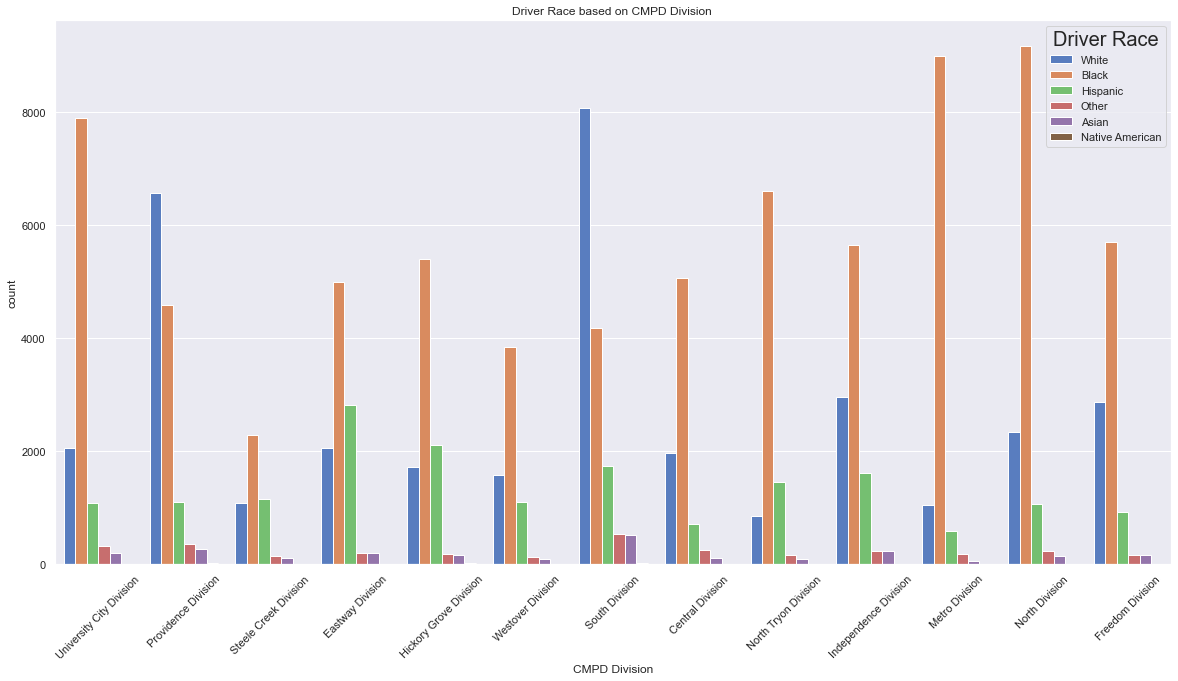

In [21]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='CMPD_Division',hue='Driver_Race',data=CMPD,palette ='muted')
ax.set(title='Driver Race based on CMPD Division ',xlabel='CMPD Division',ylabel='count')
ax.legend(title='Driver Race',title_fontsize='20',loc='upper right')
plt.xticks(rotation=45)
plt.show()

We can see that both in the South and Providence Division, White's being pulled over are in the majority. However, both University and Freedom are mostly African American. At first glance, given that those four divisions resulted in high speeding, we need to investigate why only University and Freedom resulted in higher citations.

Looking at North and Metro, we can see that the majority of stops are for African American, but remember this was mostly Regulatory stops, and they resulted in Verbal Warnings most of the time.

Earlier we discussed Officer Tenure and how it can relate to where they are stationed based on the majority of their traffic stops. Let's take a look at that now to see if the theory holds up.

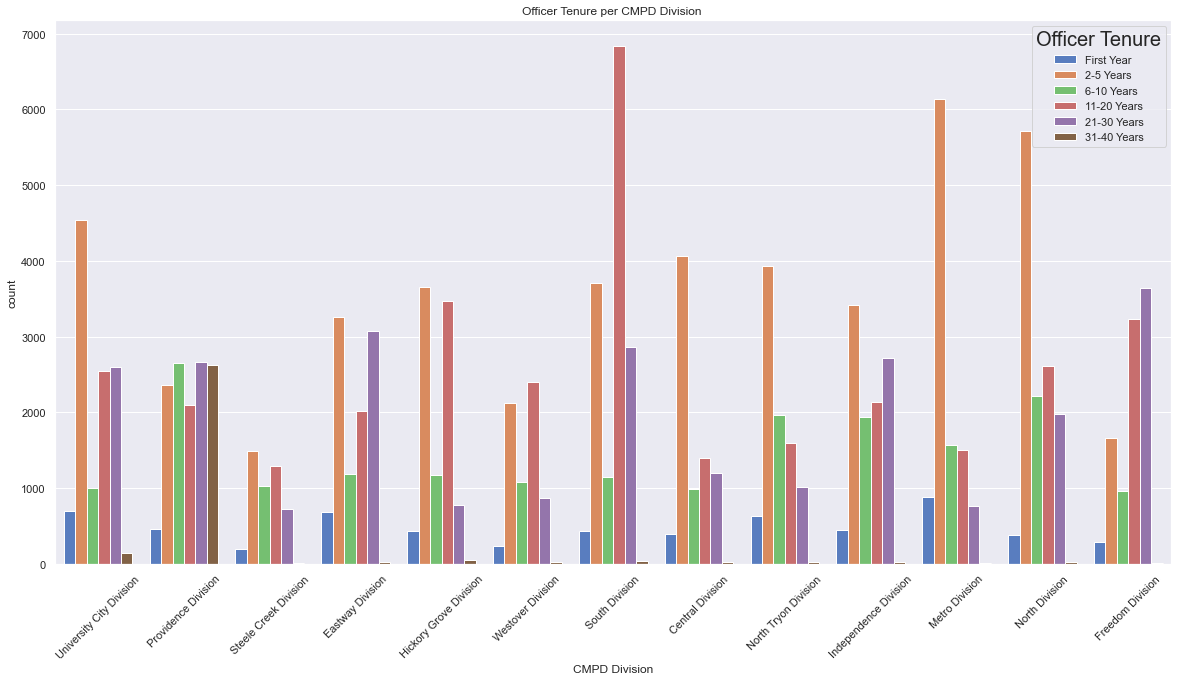

In [22]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='CMPD_Division',hue='Officer_Years_of_Service',data=CMPD,palette='muted')
ax.set(title='Officer Tenure per CMPD Division ',xlabel='CMPD Division',ylabel='count')
ax.legend(title='Officer Tenure',title_fontsize='20',loc='upper right')
plt.xticks(rotation=45)
plt.show()

Providence surprisngly seems to be pretty equally distributed. However the South and Freedom Division is predominately senior officers. Interestingly, Univeristy has a large proportion of younger officers. The areas where regulatory stops were the highest, also had large amounts of young officers.

With University, Freedom, Providence and South providing the major differences for verbal vs citation outcomes with relation to speeding and potentially race. Let's explore those a bit further.

In [23]:
providence = CMPD[CMPD['CMPD_Division'] == 'Providence Division']
university = CMPD[CMPD['CMPD_Division'] == 'University City Division']
south = CMPD[CMPD['CMPD_Division'] == 'South Division']
freedom = CMPD[CMPD['CMPD_Division'] == 'Freedom Division']

print('Providence Division')
print('-'*50)
print(providence.groupby('Driver_Race')['Result_of_Stop'].value_counts(normalize=True).mul(100)[['Black','White']])
print('-'*50)
print('University Division')
print('-'*50)
print(university.groupby('Driver_Race')['Result_of_Stop'].value_counts(normalize=True).mul(100)[['Black','White']])
print('-'*50)
print('South Division')
print('-'*50)
print(south.groupby('Driver_Race')['Result_of_Stop'].value_counts(normalize=True).mul(100)[['Black','White']])
print('-'*50)
print('Freedom Division')
print('-'*50)
print(freedom.groupby('Driver_Race')['Result_of_Stop'].value_counts(normalize=True).mul(100)[['Black','White']])
print('-'*50)

Providence Division
--------------------------------------------------
Driver_Race  Result_of_Stop 
Black        Verbal Warning     49.019180
             Citation Issued    32.955536
             Written Warning    15.148213
             No Action Taken     1.896251
             Arrest              0.980820
White        Verbal Warning     43.819540
             Citation Issued    29.599146
             Written Warning    24.798049
             No Action Taken     1.554641
             Arrest              0.228624
Name: Result_of_Stop, dtype: float64
--------------------------------------------------
University Division
--------------------------------------------------
Driver_Race  Result_of_Stop 
Black        Citation Issued    49.214195
             Verbal Warning     43.206591
             Written Warning     3.333333
             Arrest              2.712294
             No Action Taken     1.533587
White        Citation Issued    52.901024
             Verbal Warning     40.80936

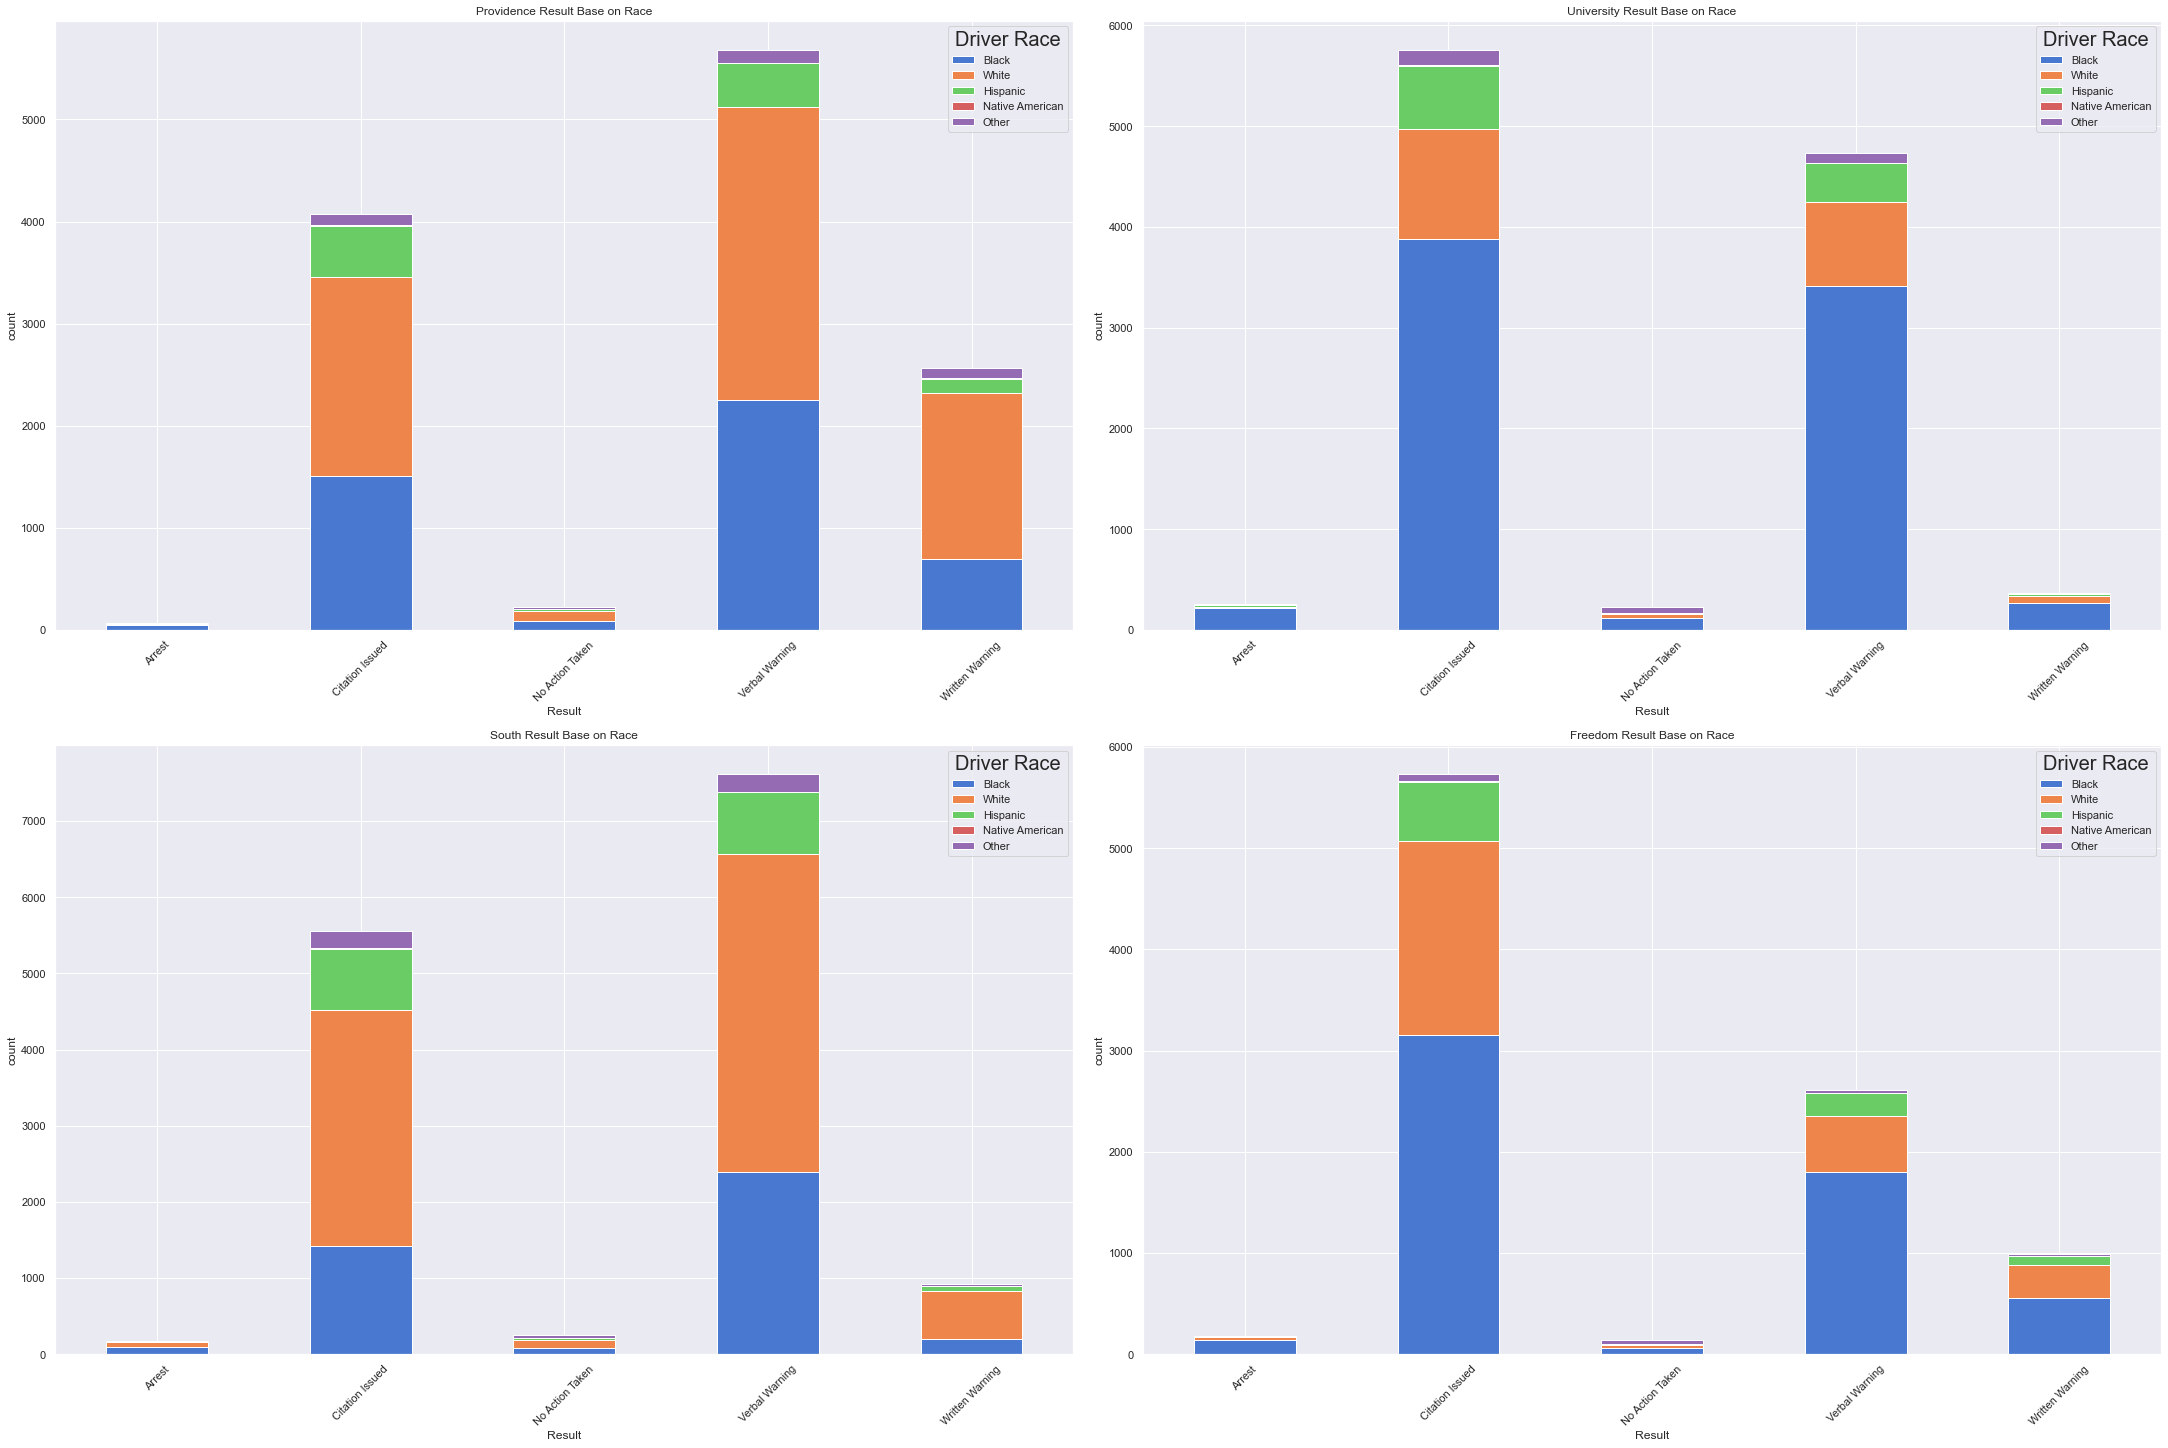

In [24]:
fig, ax = plt.subplots(2,2, figsize=(30, 20),constrained_layout=True)

stacked_plot(providence,'Result_of_Stop','Driver_Race',(0,0),order = ['Black','White','Hispanic','Native American','Other']) 
stacked_plot(university,'Result_of_Stop','Driver_Race',(0,1),order = ['Black','White','Hispanic','Native American','Other']) 
stacked_plot(south,'Result_of_Stop','Driver_Race',(1,0),order = ['Black','White','Hispanic','Native American','Other']) 
stacked_plot(freedom,'Result_of_Stop','Driver_Race',(1,1),order = ['Black','White','Hispanic','Native American','Other'])

ax[0,0].set(title='Providence Result Base on Race',xlabel='Result',ylabel='count')
ax[0,0].legend(title='Driver Race',title_fontsize='20',loc='best')

ax[0,1].set(title='University Result Base on Race',xlabel='Result',ylabel='count')
ax[0,1].legend(title='Driver Race',title_fontsize='20',loc='best')

ax[1,0].set(title='South Result Base on Race',xlabel='Result',ylabel='count')
ax[1,0].legend(title='Driver Race',title_fontsize='20',loc='best')

ax[1,1].set(title='Freedom Result Base on Race',xlabel='Result',ylabel='count')
ax[1,1].legend(title='Driver Race',title_fontsize='20',loc='best')

plt.show()

In [25]:
providence_white = providence[providence['Driver_Race'] == 'White']
providence_black = providence[providence['Driver_Race'] == 'Black']

university_white = university[university['Driver_Race'] == 'White']
university_black = university[university['Driver_Race'] == 'Black']

south_white = south[south['Driver_Race'] == 'White']
south_black = south[south['Driver_Race'] == 'Black']

freedom_white = freedom[freedom['Driver_Race'] == 'White']
freedom_black = freedom[freedom['Driver_Race'] == 'Black']

print('Providence White')
print('-'*50)
print(providence_white.groupby('Reason_for_Stop')['Result_of_Stop'].value_counts(normalize=True).mul(100)[['Speeding','Regulatory']])
print('-'*50)
print('Providence African American')
print('-'*50)
print(providence_black.groupby('Reason_for_Stop')['Result_of_Stop'].value_counts(normalize=True).mul(100)[['Speeding','Regulatory']])
print('-'*50)
print('University White')
print('-'*50)
print(university_white.groupby('Reason_for_Stop')['Result_of_Stop'].value_counts(normalize=True).mul(100)[['Speeding','Regulatory']])
print('-'*50)
print('University African American')
print('-'*50)
print(university_black.groupby('Reason_for_Stop')['Result_of_Stop'].value_counts(normalize=True).mul(100)[['Speeding','Regulatory']])
print('-'*50)
print('South White')
print('-'*50)
print(south_white.groupby('Reason_for_Stop')['Result_of_Stop'].value_counts(normalize=True).mul(100)[['Speeding','Regulatory']])
print('-'*50)
print('South African American')
print('-'*50)
print(south_black.groupby('Reason_for_Stop')['Result_of_Stop'].value_counts(normalize=True).mul(100)[['Speeding','Regulatory']])
print('-'*50)
print('Freedom White')
print('-'*50)
print(freedom_white.groupby('Reason_for_Stop')['Result_of_Stop'].value_counts(normalize=True).mul(100)[['Speeding','Regulatory']])
print('-'*50)
print('Freedom African American')
print('-'*50)
print(freedom_black.groupby('Reason_for_Stop')['Result_of_Stop'].value_counts(normalize=True).mul(100)[['Speeding','Regulatory']])
print('-'*50)

Providence White
--------------------------------------------------
Reason_for_Stop  Result_of_Stop 
Speeding         Citation Issued    37.789474
                 Written Warning    33.894737
                 Verbal Warning     27.921053
                 No Action Taken     0.315789
                 Arrest              0.078947
Regulatory       Verbal Warning     64.595104
                 Citation Issued    25.988701
                 No Action Taken     6.591337
                 Written Warning     2.542373
                 Arrest              0.282486
Name: Result_of_Stop, dtype: float64
--------------------------------------------------
Providence African American
--------------------------------------------------
Reason_for_Stop  Result_of_Stop 
Speeding         Citation Issued    42.041522
                 Verbal Warning     32.871972
                 Written Warning    24.394464
                 No Action Taken     0.475779
                 Arrest              0.216263
Regulator

Proportinately speaking, race did not affect the result of the traffic stop. Both White and African American in all areas were given either a Verbal Warning or Citation at similar percentages.

### Initial Reactions
Based on some of the categorical relationships, a few patterns have begun to emerge. If you're known to be a speeder, it's best to avoid speeding in Providence, South, Freedom, and Univeristy. If you are pulled over there, you have a higher chance of getting a citation in Freedom or University.

If you have a car that has expired registration, the first three months of the year are your most likely times to be pulled over. You'll also have a higher chance at being pulled over closer to Uptown Charlotte. Luckily if you do, it typically results in a verbal warning. 

If you are pulled over by an officer, a younger officer is more likely to give verbal warning.

### Predictive Modeling
Now that we have some initial reactions from the data, it's time to put some Machine Learning to work. We'd like to put together a model, that given all of the input parameters (month, driver race, etc.), can correctly predict the result of the traffic stop.

Since we're most interested in whether or not we'll be let off with a warning vs a citation, we can convert the data into a binary problem. This will also help our model work more effectively due to class imbalances. 

Given that our data is categorical, we need to create dummy variables for each column (1's and 0's) so our model can understand in the inputed data.

Let's begin by converting the Result of Stop into a binary class and create and input the dummy variables. We'll then shuffle the data and remove 20% to be our final holdout test set so our models will never see that data until the final test. We'll use the other 80% of the data to try out a few models with a basic split to get an idea for initial performance. We can then cross validate the 80% when we are tuning our model with Stratified KFold splits to make sure we're not overfitting the training data. Once our model is tuned to our liking with the best parameters, we'll then train the model on the whole 80% and then do the final test on our holdout set.

In [26]:
cleaned,features,target = clean_results(process_dummies(CMPD,'Result_of_Stop'),clean_result_2)
full_train,holdout = create_holdout(cleaned,.80)
full_train.head()

,Result_of_Stop,Month_of_Stop_1,Month_of_Stop_2,Month_of_Stop_3,Month_of_Stop_4,Month_of_Stop_5,Month_of_Stop_6,Month_of_Stop_7,Month_of_Stop_8,Month_of_Stop_9,Month_of_Stop_10,Month_of_Stop_11,Month_of_Stop_12,Reason_for_Stop_CheckPoint,Reason_for_Stop_DUI,Reason_for_Stop_Equipment,Reason_for_Stop_Investigation,Reason_for_Stop_Other,Reason_for_Stop_Red,Reason_for_Stop_Regulatory,Reason_for_Stop_SeatBelt,Reason_for_Stop_Speeding,Reason_for_Stop_Unsafe,Officer_Race_Asian,Officer_Race_Black,Officer_Race_Hispanic,Officer_Race_Native American,Officer_Race_White,Officer_Gender_Female,Officer_Gender_Male,Officer_Years_of_Service_First Year,Officer_Years_of_Service_2-5 Years,Officer_Years_of_Service_6-10 Years,Officer_Years_of_Service_11-20 Years,Officer_Years_of_Service_21-30 Years,Officer_Years_of_Service_31-40 Years,Driver_Race_Asian,Driver_Race_Black,Driver_Race_Hispanic,Driver_Race_Native American,Driver_Race_Other,Driver_Race_White,Driver_Gender_Female,Driver_Gender_Male,Driver_Age_Teenager,Driver_Age_20s,Driver_Age_30s,Driver_Age_40s,Driver_Age_50s,Driver_Age_60s,Driver_Age_Over 60,Was_a_Search_Conducted_No,Was_a_Search_Conducted_Yes,CMPD_Division_Central Division,CMPD_Division_Eastway Division,CMPD_Division_Freedom Division,CMPD_Division_Hickory Grove Division,CMPD_Division_Independence Division,CMPD_Division_Metro Division,CMPD_Division_North Division,CMPD_Division_North Tryon Division,CMPD_Division_Providence Division,CMPD_Division_South Division,CMPD_Division_Steele Creek Division,CMPD_Division_University City Division,CMPD_Division_Westover Division,Year_2020,Year_2021
101846,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
134622,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
104149,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
99203,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
57712,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [27]:
print(full_train['Result_of_Stop'].value_counts(normalize=True))
print(holdout['Result_of_Stop'].value_counts(normalize=True))

0    0.55527
1    0.44473
Name: Result_of_Stop, dtype: float64
0    0.557131
1    0.442869
Name: Result_of_Stop, dtype: float64


We can see that our training set and holdout set have about the same distribution of results, so we're good to go there. Also, we can see that once this is a binary problem, our classes are fairly equal. Since the classes are equal, we can put good faith in a basic accuracy metric of the predicted results. Right now with 55% of the data being a 0 (Verbal Warning), that is the baseline we'd like to beat assuming we always guessed 0.

### K Nearest Neighbors
A great model to use to get a baseline accuracy level is K Nearest Neighbors. This model uses the inputed neighbor amount and compares every unseen observation in the test set to the training observations to look for similar/nearest observations. The amount of nearest observations the model uses is specified by us. Once it finds the label with the most nearby observations, it assigns that value as the prediction.

We can try a few different neighbor amounts a run the model with the <code>'basic_classify'</code> function that I have created.

In [28]:
for i in [1,5,11,15,int(np.sqrt(full_train.shape[0]))]:
    print('Number of Neighbors: ',i)
    knn, X_train, y_train, X_test, y_test, test_predictions, cm = basic_classify(KNeighborsClassifier(n_neighbors=i),full_train,features,target)

Number of Neighbors:  1
Standard Prediction with 75/25 split - No Cross Validation
--------------------------------------------------
Accuracy on training data: 0.92
Accuracy on test data:     0.69
[[10468  4237]
 [ 3842  7901]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.71      0.72     14705
           1       0.65      0.67      0.66     11743

    accuracy                           0.69     26448
   macro avg       0.69      0.69      0.69     26448
weighted avg       0.70      0.69      0.69     26448

Number of Neighbors:  5
Standard Prediction with 75/25 split - No Cross Validation
--------------------------------------------------
Accuracy on training data: 0.81
Accuracy on test data:     0.73
[[11336  3369]
 [ 3653  8090]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.77      0.76     14705
    

From the results, 11 neighbors seems to be the best amount since increasing the neighbors from that point does not offer significantly better results. 75% accuracy is certainly better than just guessing 1 or 0 for every guess. We can also see that our F1-Score (harmonic mean of Precision and Recall) is also 75%. This is a good balance of Precision and Recall, with Precision being what proportion of drivers that we classfied as getting a citation, actually got a citaion. Where as recall is what proportion of drivers that actually got a citation was classified by the algorithm as getting a citation.

### Logistic Regression
Another great model to test would be Logistic Regression. This model is a perfect one to use for binary classification problems. Logistic Regression works by applying weights (coefficients) to the inputed parameters, and by using the Sigmoid Function, estimates the probability of a 0 or 1 by minimizing the error based on a certain probability threshold. Scikit-Learn defaults to a 50% threshold level, but when we visualize the ROC curve, we can see if a better threshold may be appropriate. 

For this model, we're going to utilize our grid search function, which will try differnt combinations of our inputed parameters to find the best score and combination of parameters.

We'll use the solver of liblinear which uses a coordinate descent algorithm by moving toward the minimum in one direction at a time. This solver also allows us to use either L1 or L2 regularization to penalize our weights. We'll try a range of different values for C which is the strength of the regularization parameter.

In [29]:
parameters = {
            'penalty': ['l1','l2'],
            'solver' : ['liblinear'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        }
lr, X_train, y_train, X_test, y_test, test_predictions, cm = basic_classify(LogisticRegression(max_iter=500),full_train,features,target,parameters=parameters)

Best Parameters:  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score:  0.7326635781746351
Standard Prediction with 75/25 split - No Cross Validation
--------------------------------------------------
Accuracy on training data: 0.73
Accuracy on test data:     0.74
[[11864  2841]
 [ 4164  7579]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.81      0.77     14705
           1       0.73      0.65      0.68     11743

    accuracy                           0.74     26448
   macro avg       0.73      0.73      0.73     26448
weighted avg       0.73      0.74      0.73     26448



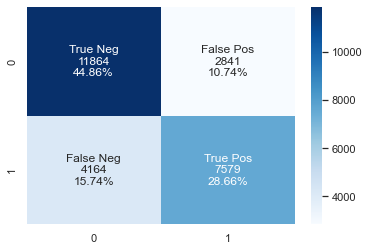

In [30]:
binary_confusion(cm)

Here we can see that the best Logistic Regression classifer was with L1 penalty and C of 10. In the above confusion matrix, we can see that the model predicted Verbal Warning correctly 11,865 times. Where as it predicted Citation correctly 7,578 times. Out of the totals, we can see that our model is much better at predicting Verbal Warning than it is at prediciting a citation.

Receiver operating characteristic, the ROC curve, plots the performance of the model based on different probability thresholds. The Threshold accounts for, when the model predicts say 55%, if the Threshold is set at 50%, the model will predict a 1. Again, the standard threshold for Scikit-Learn is 50%, but the ROC curve can visually tell us if a better threshold may be found. The plot is created by plotting the true positive rate vs. false positive rate at they various threshold settings.

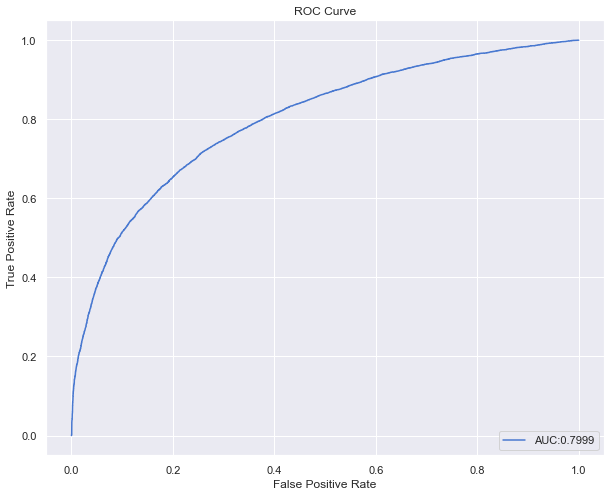

In [31]:
plt.figure(figsize=(10,8))
display_roc_curve(lr)

With an AUC score of 80%, our model does much better than a completely random classifier which would give a result of 50%. Since the ROC curve does not have any clear indication of a steep dropoff, it would really be up to us if we care more about sensitivity or specificity to change the threshold away from 50%.

### Random Forest
For our last model, we'll use a Random Forest. Individual decision tree's are great models to use, however, they are extremely prone to overfitting, especially if you don't prune the tree. Random Forest's are much better at avoiding overfitting due to the fact that they are a created through an extension of bootsrap aggregation. In other words, we can train however many trees we want in parallel, but each tree only uses a randomized with replacement subset of our original data, as well as, only a subset of the input paraments (features). The tree is then grown to however far we specify. Once all the trees are grown, the predictions are all averaged together and this results in better accuracy than a single tree typically.

We already tuned this model through a grid search, and the best parameters we found were with 500 trees, the max amount of features to use for each tree is the square root of all features, the criterion for the split is the gini index, minimum samples for a split is 15, and lastly the minimum samples to be at a leaf node is 5.

In [32]:
rfc = RandomForestClassifier(n_estimators = 500, max_features = 'sqrt', criterion = 'gini',min_samples_leaf = 5,
                            min_samples_split = 15)
rfc, X_train, y_train, X_test, y_test, test_predictions, cm = basic_classify(rfc,full_train,features,target)

Standard Prediction with 75/25 split - No Cross Validation
--------------------------------------------------
Accuracy on training data: 0.80
Accuracy on test data:     0.77
[[12557  2148]
 [ 3950  7793]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.85      0.80     14705
           1       0.78      0.66      0.72     11743

    accuracy                           0.77     26448
   macro avg       0.77      0.76      0.76     26448
weighted avg       0.77      0.77      0.77     26448



Here we can see that we've increased all of our metrics and the overall accuracy is 77%. Random Forests allow us to see overall feature importance. Here we can list the top 10 to see what features helped the model the most make accurate predictions

In [33]:
imp = rfc.feature_importances_
cols = list(features)
imp_df = pd.DataFrame({"feature": cols, "Importance": imp})
imp_sorted = imp_df.sort_values("Importance", ascending=False)
imp_sorted.head(10)

,feature,Importance
20,Reason_for_Stop_Speeding,0.213922
30,Officer_Years_of_Service_2-5 Years,0.073995
33,Officer_Years_of_Service_21-30 Years,0.066933
14,Reason_for_Stop_Equipment,0.035607
18,Reason_for_Stop_Regulatory,0.032729
54,CMPD_Division_Freedom Division,0.031974
34,Officer_Years_of_Service_31-40 Years,0.030646
31,Officer_Years_of_Service_6-10 Years,0.030256
32,Officer_Years_of_Service_11-20 Years,0.029123
17,Reason_for_Stop_Red,0.021272


Here we can see right off the bat, speeding was the number one most important feature. Then followed by officer tenure and then Equipment and Regulatory reasons. These are all features that we discussed earlier through our analysis of uncovering patterns. Interestingly enough, Race was not included in the top 10.

To make sure our model is robust, we should implement cross validation test. We'll implement a stratified 10 fold KFold cross validation and see each folds accuracy as well as the overall mean.

In [34]:
scores = cross_val_score(rfc,X = full_train[features],y = full_train[target],cv=10)
print('Overall Accuracy: ',scores.mean())
print('All Scores',scores)

Overall Accuracy:  0.7691180640892334
All Scores [0.76774742 0.76576236 0.7704887  0.77143397 0.77322998 0.76859817
 0.76859817 0.7701106  0.76680216 0.76840911]


Here we can see that even with a stratified 10 fold stratified cross validation, our model is holding up well. Lastly, now that we have our final model picked out and our holdout set has been untouched. Let's retrain the model on the full training set and put the predictions to the true test on the holdout set.

In [35]:
final_rfc = RandomForestClassifier(n_estimators = 500, max_features = 'sqrt', criterion = 'gini',
                                   min_samples_leaf = 5,min_samples_split = 15)
final_rfc.fit(full_train[features],full_train[target])
holdout_predictions = final_rfc.predict(holdout[features])
accuracy = accuracy_score(holdout[target],holdout_predictions)
print('Overall Accuracy: ',accuracy)

Overall Accuracy:  0.768489110707804


In [36]:
print(classification_report(holdout[target], holdout_predictions))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80     14735
           1       0.78      0.66      0.72     11713

    accuracy                           0.77     26448
   macro avg       0.77      0.76      0.76     26448
weighted avg       0.77      0.77      0.77     26448



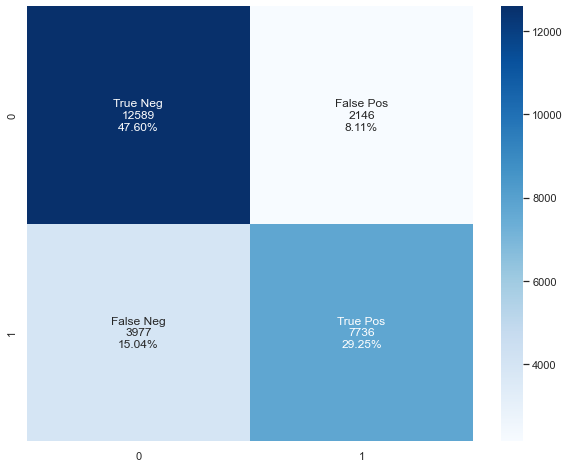

In [37]:
plt.figure(figsize=(10,8))
binary_confusion(confusion_matrix(holdout[target],holdout_predictions))

Our model performed just as well on the holdout set and better than both K Nearest Neighbors and Logistic Regression. Success!

### Conclusion
A lot of work is still to be done on this project, however, initially, we have been able to visualize and uncover some interesting patterns. We were also able to build a decent predictive model with 77% accuracy.